\# Solving the Advection Equation (Hamiltonian Simulation)

In the notebook we use Classiq SDK to perform Hamiltonian simulation to compare with method proposed in the paper [Yuki Sato et al., Hamiltonian simulation for hyperbolic partial differential equations by scalable quantum circuits", PhysRevResearch.6.033246](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033246) as well with Matrix-vector calculation and exact solution of Finite Differences Method (FDM).

The advection equation can be described by the following differential equation:

$$
\frac{\partial \phi}{\partial t} + \frac{\partial \phi}{\partial x} = 0
$$

In this case, the velocity parameter $v$ is assumed to be equal to 1. The initial conditions in the challenge are given as Dirichlet boundary conditions (BC):
$$
\phi(t=0, x) = \begin{cases}
1, & \mbox{if } 1 < x < 2 \\  
0, & \mbox{otherwise}
\end{cases}
$$

The task is to solve the advection equation at time $t = 1$. However, the problem does not specify the domain of $x$ over which the problem should be solved. Given $v = 1$ and $T = 1$, we determined that the optimal domain for $x$ is $x \in [-1, 4]$, otherwise the solver diverges due to required Dirichlet boundary conditions.

## Install and Import Modules

Run 2 following cells, if You are running the notebook in Google Colab.

In [1]:
# %%capture
# !pip install -U classiq

In [ ]:
# import classiq
# classiq.authenticate()
# print("Current version:", classiq.__version__)

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classiq import *
from classiq.execution import ExecutionJob
from classiq.qmod.symbolic import floor

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Exact Solution (FDM)

In order to solve classically the advection equation with Finite Differences Method (FDM), we use fourth-order Runge-Kutta (RK4) integration scheme, which is a more advanced than Forward Euler method. The Forward Euler (FE) method is simple but only accurate to first order in time, meaning that the error per step is proportional to ${dt}^2$. The cumulative error over all time steps is therefore proportional to $dt$, which can lead to significant inaccuracies if $dt$ is not sufficiently small. The RK4 method, implemented as `rk4` function below, is accurate to fourth order in time, meaning the error per step is proportional to ${dt}^5$. The cumulative error over all steps is proportional to ${dt}^4$, which can be significantly smaller than that of the FE method, especially for smaller time steps.

The spatial domain need to be sufficiently wide in order to ensure that the wave does not interact with the boundaries during the state evolution time, therefore we have chosen. We are checking also Courant-Friedrichs-Lewy (CFL) condition for stability of advection equation solutions:
$$
\text{CFL} = |v|\frac{\Delta t}{\Delta x} \leq 1.
$$

Helper functions:
- `create_dirichlet_operator`: Creates the D operator for the advection equation with Dirichlet boundary conditions.
- `rk4`: Solves the system of PDEs using the Runge-Kutta 4th order method
- `euler`: Evolves the initial state using the Forward Euler Method.

In [3]:
def create_dirichlet_operator(N, dx, BC=None):
    """
    Creates the D operator for the advection equation with Dirichlet boundary conditions.

    Parameters:
        N (int): The number of grid points.
        dx (float): The spatial step size.
        BC (string): Boundary condiditons. Default is `None`, which is Dirichlet BC. Another oprtion is `periodic`.

    Returns:
        numpy.ndarray: The D operator matrix.
    """
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i - 1 == j:
                D[i, j] = -1 / (2 * dx)
            if i == j - 1:
                D[i, j] = 1 / (2 * dx)

    if BC == "periodic":
        D[0, N - 1] = -1 / (2 * dx)
        D[N - 1, 0] = 1 / (2 * dx)
    return D

In [4]:
def rk4(v, y, D, dt, Nt):
    """
    Solves the system of PDEs using the Runge-Kutta 4th order method. Solution at the next time step is updated in-place.

    Parameters:
    v (float): Coefficient in the equation, could represent velocity or other factors.
    y (numpy.ndarray): 2D array where each column represents the solution at a time step.
    D (numpy.ndarray): Matrix used in the system of equations, e.g., a differentiation matrix.
    dt (float): Time step size.
    Nt (int): Number of time steps.

    Updates: y[:, i+1]
    """

    for i in range(Nt - 1):  # Loop through each time step
        # Calculate intermediate slopes using RK4 formula
        k1 = -v * (D @ y[:, i])
        k2 = -v * (D @ (y[:, i] + dt / 2 * k1))
        k3 = -v * (D @ (y[:, i] + dt / 2 * k2))
        k4 = -v * (D @ (y[:, i] + dt * k3))

        # Update solution for the next time step
        y[:, i + 1] = y[:, i] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [5]:
def euler(v, y, D, dt, Nt):
    """
    Evolves the initial state using the Forward Euler Method. Solution at the next time step is updated in-place.

    Parameters:
    v (float): Coefficient in the equation, could represent velocity or other factors.
    y (numpy.ndarray): 2D array where each column represents the solution at a time step.
    D (numpy.ndarray): Matrix used in the system of equations, e.g., a differentiation matrix.
    dt (float): Time step size.
    Nt (int): Number of time steps.

    Updates: y[:, i+1]
    """

    for i in range(Nt - 1):  # Loop through each time step
        # Compute the derivative (dy/dt) using the current state
        dy = -v * (D @ y[:, i])

        # Update the solution to the next time step using Euler's formula
        y[:, i + 1] = y[:, i] + dt * dy

In [69]:
# Number of qubits
n = 7
num_qubits = n

# Velocity
v = 1

# Evolution time
T = 1
evoultion_time = T

# Time step chosen to fulfill CFL condition
dt = 0.038


t = np.arange(0, T + dt, dt)
Nt = len(t)

N = 2**n

# Domain interval (-1,4)
# Lower bound of interval
lb = -1
# Upper bound of interval
ub = 4

# Space domain
x = np.linspace(lb, ub, N)

dx = (x[-1] - x[0]) / (N - 1)

CFL = v * dt / dx
print(f"CFL condition: {CFL}")

CFL condition: 0.9652


We create D operator for Dirichlet boundary conditions.

In [7]:
# Create D operator with Dirichlet conditions
D = create_dirichlet_operator(N, dx)

We initiate $\phi$ function variable `y` and normalize initial vector, which will be used lated for initial state preparation. The initial vector is created with required condition:
$$
\phi(t=0, x) = \begin{cases}
1, & \mbox{if } 1 < x < 2 \\  
0, & \mbox{otherwise}
\end{cases}
$$

In [70]:
# Initiate function variable
y = np.zeros((N, Nt))

# Initial conditons at time t=0
y[np.logical_and(x > 1, x < 2), 0] = 1
initial_vector = y[:, 0]

# Normalization
normalization_coefficient = np.linalg.norm(initial_vector)
normal_vector = initial_vector / normalization_coefficient
y[:, 0] = normal_vector

We plot advection equation solution for three time points t = 0, 0.5 and 1.

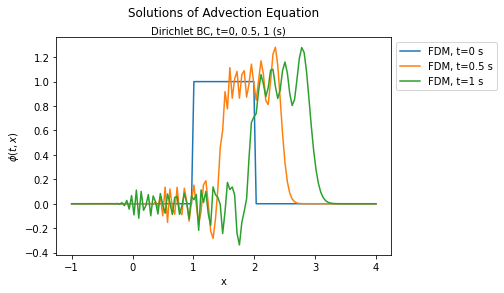

In [71]:
# Solving equation using Runge-Kutta 4-th order method
rk4(v, y, D, dt, Nt)

# Evolution of the initial state with D operator using Forward Euler Method
# euler(v, y, D, dt, Nt)

time_points = [0, 0.5, 1]  # [0, T]

plt.figure()
for i, evolution_time in enumerate(time_points):
    idx = int(evolution_time / dt)
    plt.plot(
        x, y[:, idx] * normalization_coefficient, label=f"FDM, t={evolution_time} s"
    )

plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(
    f"Dirichlet BC, t={', '.join(map(str, time_points))} (s)", y=0.92, fontsize=10
)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Exact solution for `t=1`

Solution of the advection equation with evolution time equal 1 second.

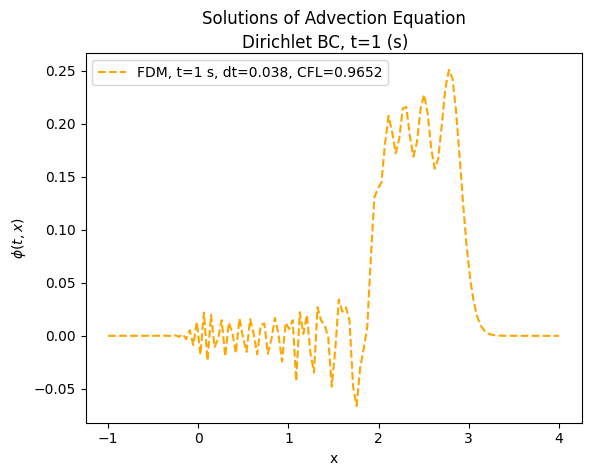

In [11]:
# Index of the vector for T=1
idx = int(T / dt)

# Exact solution for t=1
exact_solution = y[:, idx]  # 100'th column for dt=0.01

# Variable for checking CFL condition
CFL = np.abs(v) * dt / dx

assert CFL <= 1, "CFL condition not satisfied"

plt.figure()
plt.plot(
    x,
    exact_solution,
    label=f"FDM, t={T} s, dt={dt}, CFL={CFL}",
    color="orange",
    linestyle="dashed",
)
plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(f"Dirichlet BC, t={T} (s)", y=0.92)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")
plt.legend()
plt.show()

# Approximated Hamiltonian Simulations

## Matrix-vector Calculation

To simulate the Hamiltonian dynamics over the total time T, it suffices to divide the total time T into $r = \frac{T}{\tau}$ intervals so that the approximation error occurred in the time interval $\tau$ could be small enough to be acceptable. The classical simulation up to time T (`t`) within the additive error $\epsilon$ requires $O(T^2/\epsilon)$ steps (p. 9-10, in the paper:
$$
r \geq \frac{\gamma^2T^2(n-1)\sum_{\alpha=1}^{d}{\eta_\alpha^2}}{2\epsilon}
$$

In [12]:
gamma = 1 / (2 * dx)
T = 1
# n = 7
epsilon = 0.1
r = (gamma**2 * T**2 * (n - 1)) / (2 * epsilon)
r

4838.7

We will use only 45 steps to approximate the solution and compare the results of Proposed and Suzuki-Trotter method, by calculating state vector fidelity. Note that right now, the steps are set to 10 to pass Classiq tests.

The Hamiltonian, being the unitary solution of advection equation transformed to Shrödinger equation, is defined as $H = -i v D_{D}^{\pm}$, for Dirichlet boundary conditions. Therefore, the exponential operator to be applied to initial state in $\tau$ time intervals can be simplified in the following way: $e^{-i H t} = e^{-i (-i D_{D}^{\pm}) t} = e^{-D_{D}^{\pm} t}$

In [13]:
from scipy.linalg import expm

T = 1
steps = 10  # you can try the results with more steps. The value 10 is set to pass the Classsiq tests

matrix_vector_simulation = []

state = normal_vector  # Normalized initial vector
for _ in range(steps):
    state = expm(-T / steps * D) @ state
    matrix_vector_simulation.append(state)

### Visualize (Matrix-vector)

#### Solution

The solution is denormalized to plot the value of $\phi(t=1, x)$.

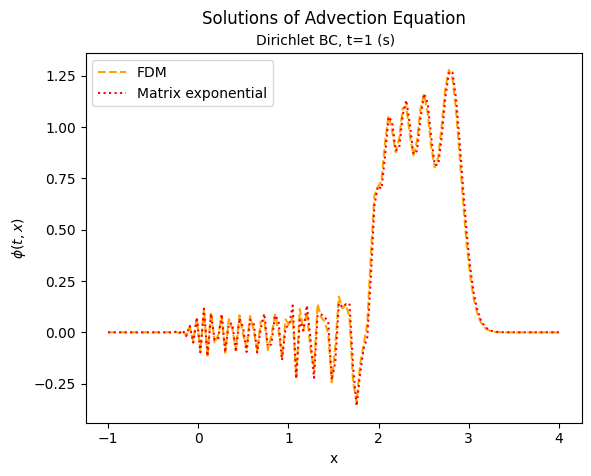

In [14]:
plt.figure()
plt.plot(
    x,
    exact_solution * normalization_coefficient,
    label=f"FDM",
    color="orange",
    linestyle="dashed",
)
plt.plot(
    x,
    matrix_vector_simulation[-1] * normalization_coefficient,
    label=f"Matrix exponential",
    color="red",
    linestyle="dotted",
)
plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(f"Dirichlet BC, t={T} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")
plt.legend()
plt.show()

#### Trotter Error

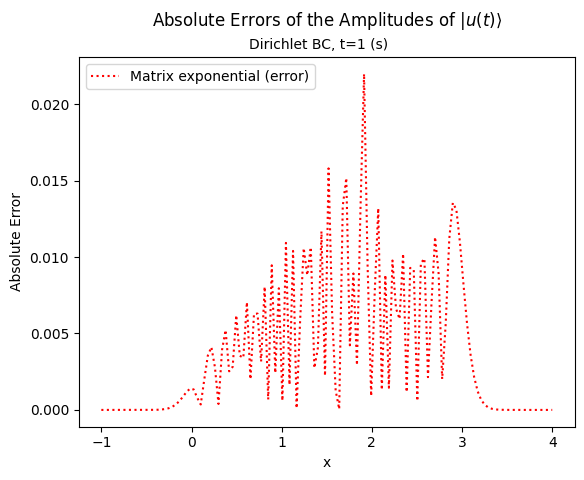

In [15]:
plt.figure()
plt.plot(
    x,
    np.abs(exact_solution - matrix_vector_simulation[-1]),
    label=f"Matrix exponential (error)",
    color="red",
    linestyle="dotted",
)
plt.title(f"Absolute Errors of the Amplitudes of " + r"$|u(t)\rangle$" + "\n")
plt.suptitle(f"Dirichlet BC, t={T} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

## Define Hamiltonian

We perform Pauli decomposition with Classiq function `matrix_to_hamiltonian`. The number of Pauli terms is $2^n - 1$.

In [16]:
# n = 7 # n is defined in FDM solution
# N = 2 ** n
# D = create_dirichlet_operator(N, dx)

# Pauli decoposition of Hamiltonian matrix
HAMILTONIAN = matrix_to_hamiltonian(-1j * v * D)
print("Number of Pauli terms:", len(HAMILTONIAN))

Number of Pauli terms: 127


## Backend Preferences

All the simulations are performed with statevector simulator from Classiq and `custom` transpilation option.

In [53]:
from classiq import QuantumProgram
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)

preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    random_seed=1235,
    timeout_seconds=600,
    optimization_timeout_seconds=100,
    transpilation_option="custom",
)

## Proposed Method

### Define W-Operator

W operator from the paper $W_j(\gamma \tau, \lambda)$ is defined with the following functions in Classiq SDK:
- `entangling_layer` - the entangling layer of W operator applying CNOT gates, Phase gate and Hadamard gate.
- `W0` - circuit W for $j = 0$.
- `mcrz` - Multi-Control-RZ gate is implemented straightforwardly, using Classiq function.
- `W` - the W operator is defined with [`within_apply`](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/within-apply) function.

Parameters of `W` function:
- `params[0]` - the $\lambda$ parameter value is chosen to be $-\frac{\pi}{2}$, in order to create $W$ operator for Hamiltonian defined with $D^{\pm}_D$ matrix.
- `params[1]` - $\gamma$ parameter, $\gamma = \frac{1}{2 \cdot \Delta x}$.
- `params[2]` - $\tau$ parameter, defined as $\tau = \text{T}/r$, where $r$ - is the number of Trotter steps, T - evolution time.

In [18]:
# Chains of CNOT gates for more than one qubit with phase shift and Hadamard gate


@qfunc
def entangling_layer(j: CInt, alpha: CReal, q: QArray[QBit]):
    if_(
        condition=j > 0,
        then=lambda: repeat(count=j, iteration=lambda i: CX(q[j], q[i])),
        else_=lambda: None,
    )
    PHASE(alpha, q[j])
    H(q[j])


# Case for one qubit W gate
@qfunc
def W0(phase_angle: CReal, rz_angle: CReal, q: QArray[QBit]):
    PHASE(phase_angle, q[0])
    H(q[0])
    RZ(rz_angle, q[0])
    H(q[0])
    PHASE(-phase_angle, q[0])


# Multi-control-RZ rotation gate
@qfunc
def mcrz(angle: CReal, cntrl: QArray[QBit], target: QBit) -> None:
    if_(
        condition=cntrl.len > 0,
        then=lambda: control(ctrl=cntrl, stmt_block=lambda: RZ(angle, target)),
        else_=lambda: None,
    )


# W gate is implemented using `within_apply` function
@qfunc
def W(index: CInt, params: CArray[CReal], q: QArray[QBit]):
    if_(
        condition=index > 0,
        then=lambda: within_apply(
            within=lambda: entangling_layer(index, params[0], q),
            apply=lambda: mcrz(2 * params[1] * params[2], q[0:index], q[index]),
        ),
        else_=lambda: W0(params[0], 2 * params[1] * params[2], q),
    )

### Define V Operator

The initial state is prepared with `prepare_amplitudes` function.

In [19]:
# V Operator parameters
num_qubits = n  # n = 7
# Time increment `tau` parameter
T = 1
steps_proposed = 10  # the greater the number of steps, the more accurate the result. Hovever, the compilation time is also greater.
tau_proposed = T / steps_proposed


@qfunc
def V(params: CArray[CReal], q: QArray[QBit]):
    repeat(count=q.len, iteration=lambda index: W(index, params, q))


@qfunc
def main(q: Output[QArray[QBit, num_qubits]]):

    # Prepare initial state
    prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)

    # Apply V operators for each Trotter step
    repeat(
        count=steps_proposed,
        iteration=lambda index: V(params=[-np.pi / 2, 1 / (2 * dx), tau_proposed], q=q),
    )

### Create Model

The constraint for maximum number of qubits set with `max_width` is needed to keep the number of qubits fixed for transpilation of multi-control-RZ gates by Classiq. Without `max_width` constraint the MCRZ is created on different number of qubits than is descibed in the algorithm.

In [20]:
# Create Quantum Model and Synthesize
qmod = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
constraints = Constraints(max_width=num_qubits)
qmod = set_constraints(qmod, constraints)
qmod = set_preferences(qmod, preferences)
qprog = synthesize(qmod)

### Execute Quantum Program

In [21]:
res_proposed = execute(qprog)

#### Check Execution Status

In [22]:
# Collected job data by id
print("Job ID:", res_proposed.id)
restored_job_proposed = ExecutionJob.from_id(res_proposed.id)
print(restored_job_proposed.status)

Job ID: 102100ed-1c78-41f1-8b8c-7a5f6ed70b1f
JobStatus.RUNNING


### Result (Proposed)

In [23]:
result_proposed = restored_job_proposed.result()

### Post-process State Vector

In [24]:
# Number of qubits
num_qubits = n
num_states = 2**num_qubits

# Initialize an array of zeros
amplitudes_proposed = np.zeros(num_states, dtype=complex)

# Fill in the values from the dictionary
for bitstring, amplitude in result_proposed[0].value.state_vector.items():
    index = int(bitstring, 2)  # Convert binary string to decimal index
    amplitudes_proposed[index] = amplitude

#### Global Phase Correction

Hamiltonian state vector simulation result includes an arbitrary global phase. The global phase can arise due to the transpilation process or from the intrinsic properties of the quantum functions themselves. Therefore, to compare with the classical solution, we need to correct the quantum results by the global phase (normalize). However, even after this normalization, there may still be a minus sign difference between the quantum and classical solutions, due to the inherent ambiguity of a global phase factor of $e^{-i\pi} = -1$. The sign difference does not affect the physical validity of the comparison, as both states $|u(t)\rangle$ and $-|u(t)\rangle$ are considered equivalent in terms of their measurement probabilities.

In [25]:
def correct_global_phase(amplitudes, reference_solution):
    """
    Corrects the global phase of quantum simulation amplitudes to match a reference solution.

    Parameters:
        amplitudes (numpy.ndarray): Input amplitudes to be corrected.
        reference_solution (numpy.ndarray): The reference solution amplitudes for comparison.

    Returns (numpy.ndarray):
        Corrected amplitudes with global phase and sign ambiguity resolved.
    """
    # Determine the index of the maximum element
    idx_max = np.argmax(np.abs(amplitudes))

    # Calculate the global phase from the maximum element
    global_phase = np.angle(amplitudes[idx_max])

    # Correct the global phase
    amplitudes_corrected = np.real(amplitudes / np.exp(1j * global_phase))

    # Correct the sign ambiguity
    sign_correction = np.sign(amplitudes_corrected[idx_max]) * np.sign(
        reference_solution[idx_max]
    )
    amplitudes_corrected *= sign_correction

    return amplitudes_corrected

In [26]:
amplitudes_proposed_corrected = correct_global_phase(
    amplitudes_proposed, exact_solution
)

### Visualize (Proposed)

#### Solutions

We define `fidelity` function to calculate measure of the similarity between the corrected quantum state amplitudes and the reference solution.

In [27]:
def compute_fidelity(amplitudes_corrected, reference_solution):
    """
    Computes the fidelity between the corrected amplitudes and a reference solution.

    Parameters:
        amplitudes_corrected (numpy.ndarray): Corrected amplitudes from a quantum simulation.
        reference_solution (numpy.ndarray): Exact solution amplitudes.

    Returns (float):
        The fidelity, a value between 0 and 1 indicating the similarity between the two states.
    """
    # Normalize the reference solution
    reference_solution_normalized = reference_solution / np.linalg.norm(
        reference_solution
    )

    # Compute the fidelity
    fidelity = np.abs(np.dot(amplitudes_corrected, reference_solution_normalized)) ** 2

    return fidelity

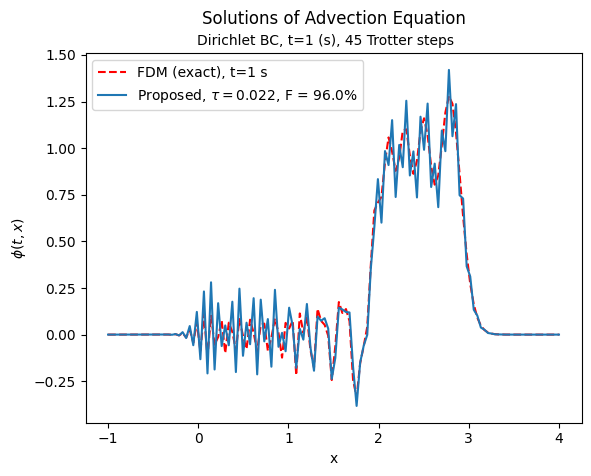

In [28]:
fidelity_proposed = compute_fidelity(amplitudes_proposed_corrected, exact_solution)

plt.figure()
plt.plot(
    x,
    exact_solution * normalization_coefficient,
    label=f"FDM (exact), t={T} s",
    linestyle="--",
    color="red",
)
plt.plot(
    x,
    amplitudes_proposed_corrected * normalization_coefficient,
    label=f"Proposed"
    + r", $\tau=$"
    + f"{np.round(1/steps, 3)}, F = {np.round(fidelity_proposed*100, 2)}%",
)

plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(
    f"Dirichlet BC, t={evolution_time} (s), {steps_proposed} Trotter steps",
    y=0.92,
    fontsize=10,
)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")
plt.legend()
plt.show()

#### Trotter Error

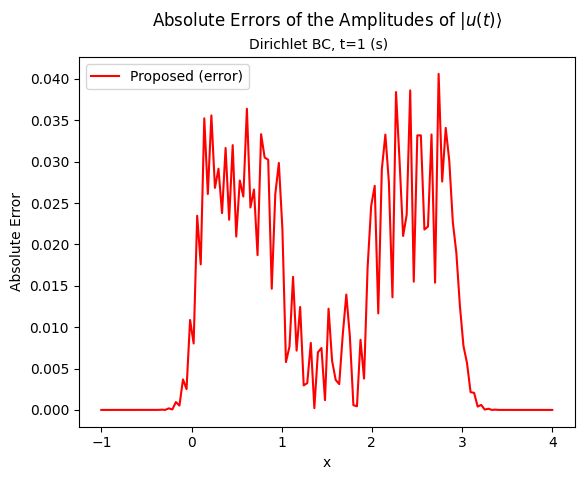

In [29]:
plt.figure()
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_proposed_corrected),
    label=f"Proposed (error)",
    color="red",
)
plt.title(f"Absolute Errors of the Amplitudes of " + r"$|u(t)\rangle$" + "\n")
plt.suptitle(f"Dirichlet BC, t={evolution_time} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

## Suzuki-Trotter

Quantum function defining Hamiltonian simulation with Suzuki-Trotter method.

In [30]:
num_qubits = n

# r = T/tau
T = 1
steps_trotter = 10  # same here, value set in order to pass tests.
tau_trotter = T / steps_trotter


@qfunc
def main(q: Output[QArray[QBit, num_qubits]]):
    # allocate(num_qubits, q)
    # create_initial_state(q)
    prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=T,  # T = 1
        order=1,
        repetitions=steps_trotter,
        qbv=q,
    )

### Create Model

In [31]:
qmod = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
constraints = Constraints(
    max_width=num_qubits
)  # , optimization_parameter=OptimizationParameter.WIDTH
qmod = set_constraints(qmod, constraints)
qmod = set_preferences(qmod, preferences)
qprog = synthesize(qmod)

In [32]:
res_trotter = execute(qprog)

#### Check Execution Status

In [33]:
# Collected job data by id
print("Job ID:", res_trotter.id)
restored_job_trotter = ExecutionJob.from_id(res_trotter.id)
print(restored_job_trotter.status)

Job ID: 5e13cecb-0548-47e7-b4da-bd8af2bcd9c4
JobStatus.RUNNING


### Result (Suzuki-Trotter)

In [34]:
result_trotter = res_trotter.result()

### Post-process State Vector

In [35]:
# Number of qubits
num_qubits = n
num_states = 2**num_qubits

# Initialize an array of zeros
amplitudes_trotter = np.zeros(num_states, dtype=complex)

# Fill in the values from the dictionary
for bitstring, amplitude in result_trotter[0].value.state_vector.items():
    index = int(bitstring, 2)  # Convert binary string to decimal index
    amplitudes_trotter[index] = amplitude

#### Global Phase Correction

In [36]:
amplitudes_trotter_corrected = correct_global_phase(amplitudes_trotter, exact_solution)

### Visualize (Suzuki-Trotter)

#### Solution

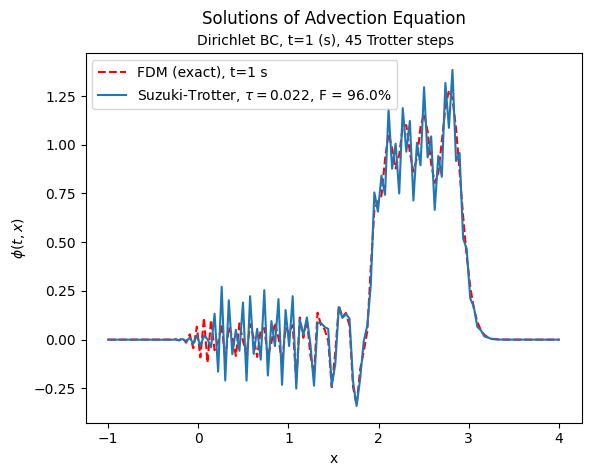

In [37]:
fidelity_trotter = compute_fidelity(amplitudes_trotter_corrected, exact_solution)

plt.figure()
plt.plot(
    x,
    exact_solution * normalization_coefficient,
    label=f"FDM (exact), t={evolution_time} s",
    linestyle="--",
    color="red",
)
plt.plot(
    x,
    amplitudes_trotter_corrected * normalization_coefficient,
    label=f"Suzuki-Trotter"
    + r", $\tau=$"
    + f"{np.round(T/steps, 3)}, F = {np.round(fidelity_trotter*100, 2)}%",
)

plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(
    f"Dirichlet BC, t={T} (s), {steps_trotter} Trotter steps", y=0.92, fontsize=10
)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")
plt.legend()
plt.show()

#### Trotter Error

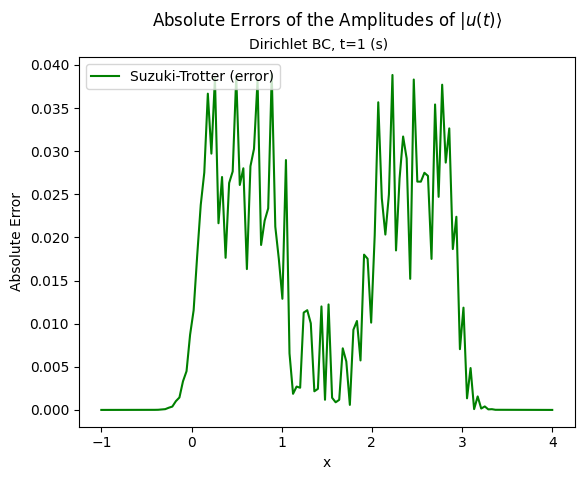

In [38]:
plt.figure()
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_trotter_corrected),
    label=f"Suzuki-Trotter (error)",
    color="green",
)
plt.title(f"Absolute Errors of the Amplitudes of " + r"$|u(t)\rangle$" + "\n")
plt.suptitle(f"Dirichlet BC, t={evolution_time} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.legend(loc="upper left")
plt.show()

## Proposed Method (custom MCRZ)

### Special decomposition of MCRZ

Special decomposition of Multi-control-RZ (MCRZ) gate has been implemented using [`bind`](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/bind/) function as described in [R. Vale et al., "Decomposition of Multi-controlled Special Unitary Single-Qubit Gates", arXiv:2302.06377](https://arxiv.org/abs/2302.06377).

In [39]:
@qfunc
def my_mcrz(index: CInt, angle: CReal, q: QArray[QBit]) -> None:
    target = QArray(
        "target", QBit, 1
    )  # q.size - cntrl.size - cntrl1.size) # Target qubit (one qubit)
    cntrl = QArray(
        "cntrl", QBit, floor(index / 2)
    )  # index-1) # Control qubits minus two
    cntrl1 = QArray(
        "cntrl1", QBit, q.size - cntrl.size - target.size
    )  # 1) # Last control qubits

    # Bind control, target, and rest to match the full `q` size
    bind(q, [cntrl, cntrl1, target])

    # Apply controlled-X to the target with `cntrl` as the control qubits
    control(ctrl=cntrl, stmt_block=lambda: X(target[0]))
    RZ(-angle / 4, target[0])
    control(ctrl=cntrl1, stmt_block=lambda: X(target[0]))
    RZ(angle / 4, target[0])
    control(ctrl=cntrl, stmt_block=lambda: X(target[0]))
    RZ(-angle / 4, target[0])
    control(ctrl=cntrl1, stmt_block=lambda: X(target[0]))
    RZ(angle / 4, target[0])

    # Rebind `cntrl`, `target`, and `rest` back to `q` to restore original structure
    bind([cntrl, cntrl1, target], q)


@qfunc
def my_mcrz_special(index: CInt, angle: CReal, q: QArray[QBit]):
    # Apply multi-controlled-RZ if `index > 1`, otherwise apply RZ directly to `q[0]`
    if_(
        condition=index > 1,
        then=lambda: my_mcrz(index, angle, q),
        else_=lambda: if_(
            condition=index > 0,
            then=lambda: control(ctrl=q[0], stmt_block=lambda: RZ(angle, q[1])),
            else_=lambda: RZ(angle, q[0]),  # index == 0
        ),
    )

### Define W-Operator

W operator from the paper $W_j(\gamma \tau, \lambda)$ is defined with the following functions in Classiq SDK:
- `entangling_layer` - the entangling layer of W operator applying CNOT gates, Phase gate and Hadamard gate.
- `W0` - circuit W for $j = 0$.
- `my_mcrz_special` - Multi-Control-RZ gate implemented as described in [R. Vale et al., "Decomposition of Multi-controlled Special Unitary Single-Qubit Gates", arXiv:2302.06377](https://arxiv.org/abs/2302.06377)..
- `W` - the W operator is defined with [`within_apply`](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/within-apply) function.

Parameters of `W_custom` function:
- `params[0]` - the $\lambda$ parameter value is chosen to be $-\frac{\pi}{2}$, in order to create $W$ operator for Hamiltonian defined with $D^{\pm}_D$ matrix.
- `params[1]` - $\gamma$ parameter, $\gamma = \frac{1}{2 \cdot \Delta x}$.
- `params[2]` - $\tau$ parameter, defined as $\tau = \text{T}/r$, where $r$ - is the number of Trotter steps, T - evolution time.

In [40]:
# Chains of CNOT gates for more than one qubit with phase shift and Hadamard gate


@qfunc
def entangling_layer(j: CInt, alpha: CReal, q: QArray[QBit]):
    if_(
        condition=j > 0,
        then=lambda: repeat(count=j, iteration=lambda i: CX(q[j], q[i])),
        else_=lambda: None,
    )
    PHASE(alpha, q[j])
    H(q[j])


# Case for one qubit W gate
@qfunc
def W0(phase_angle: CReal, rz_angle: CReal, q: QArray[QBit]):
    PHASE(phase_angle, q[0])
    H(q[0])
    RZ(rz_angle, q[0])
    H(q[0])
    PHASE(-phase_angle, q[0])


# W gate is implemented using `within_apply` function, but uses custom decomposition of MCRZ defined in function `my_mcrz_special`
@qfunc
def W_custom(index: CInt, params: CArray[CReal], q: QArray[QBit]):
    if_(
        condition=index > 0,
        then=lambda: within_apply(
            within=lambda: entangling_layer(index, params[0], q),
            apply=lambda: my_mcrz_special(
                index, 2 * params[1] * params[2], q[0 : index + 1]
            ),
        ),
        else_=lambda: W0(params[0], 2 * params[1] * params[2], q),
    )

In [41]:
# V Operator parameters
num_qubits = n  # n = 7
# Time increment `tau` parameter
T = 1
steps_proposed_custom = 10  # the greater the number of steps, the more accurate the result. Hovever, the compilation time is also greater.
tau_proposed_custom = T / steps_proposed_custom


@qfunc
def V_custom(params: CArray[CReal], q: QArray[QBit]):
    repeat(count=q.len, iteration=lambda index: W_custom(index, params, q))


@qfunc
def main(q: Output[QArray[QBit, num_qubits]]):

    # Prepare initial state
    prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)

    # Apply V operators for each Trotter step
    repeat(
        count=steps_proposed,
        iteration=lambda index: V_custom(
            params=[-np.pi / 2, 1 / (2 * dx), tau_proposed_custom], q=q
        ),
    )

### Create Model

In [42]:
# Create Quantum Model and Synthesize
qmod = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
constraints = Constraints(max_width=num_qubits)
qmod = set_constraints(qmod, constraints)
qmod = set_preferences(qmod, preferences)
qprog = synthesize(qmod)
# show(qprog)

In [43]:
res_proposed_custom = execute(qprog)

#### Check Execution Status

In [44]:
# Collected job data by id
print("Job ID:", res_proposed_custom.id)
restored_job_proposed_custom = ExecutionJob.from_id(res_proposed_custom.id)
print(restored_job_proposed_custom.status)

Job ID: 986d1b21-a66f-4c0f-a8aa-b2a6a1526c96
JobStatus.QUEUED


### Result (Proposed custom MCRZ)

In [45]:
result_proposed_custom = res_proposed_custom.result()

### Post-process State Vector

In [46]:
# Number of qubits
num_qubits = n
num_states = 2**num_qubits

# Initialize an array of zeros
amplitudes_proposed_custom = np.zeros(num_states, dtype=complex)

# Fill in the values from the dictionary
for bitstring, amplitude in result_proposed_custom[0].value.state_vector.items():
    index = int(bitstring, 2)  # Convert binary string to decimal index
    amplitudes_proposed_custom[index] = amplitude

#### Global Phase Correction

In [47]:
amplitudes_proposed_custom_corrected = correct_global_phase(
    amplitudes_proposed_custom, exact_solution
)

### Visualize (V custom MCRZ)

#### Solution

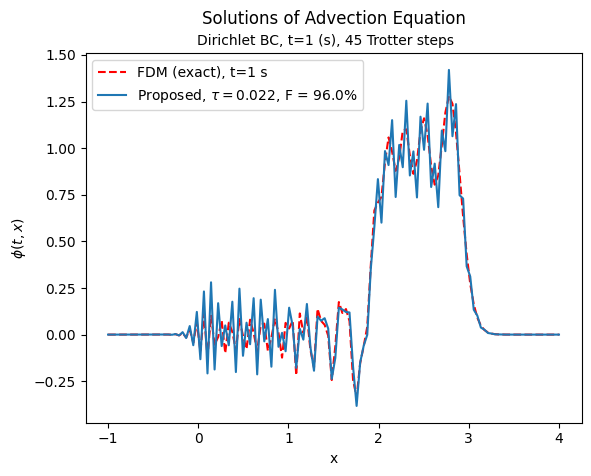

In [48]:
fidelity_proposed_custom = compute_fidelity(
    amplitudes_proposed_custom_corrected, exact_solution
)

plt.figure()
plt.plot(
    x,
    exact_solution * normalization_coefficient,
    label=f"FDM (exact), t={T} s",
    linestyle="--",
    color="red",
)
plt.plot(
    x,
    amplitudes_proposed_custom_corrected * normalization_coefficient,
    label=f"Proposed"
    + r", $\tau=$"
    + f"{np.round(1/steps_proposed_custom, 3)}, F = {np.round(fidelity_proposed_custom*100, 2)}%",
)

plt.title(f"Solutions of Advection Equation\n")
plt.suptitle(
    f"Dirichlet BC, t={evolution_time} (s), {steps_proposed_custom} Trotter steps",
    y=0.92,
    fontsize=10,
)
plt.xlabel("x")
plt.ylabel(r"$\phi(t, x)$")
plt.legend()
plt.show()

#### Trotter Error

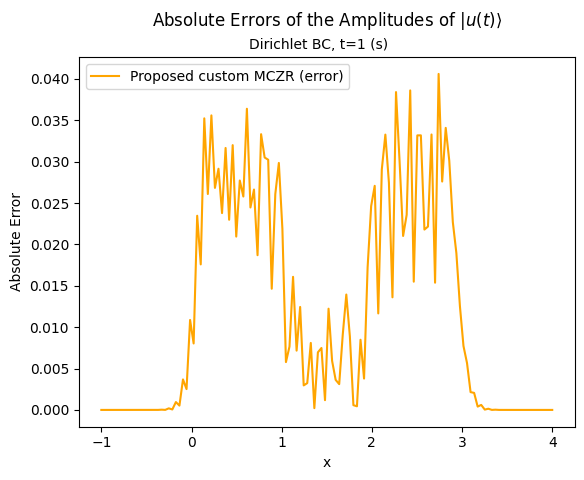

In [49]:
plt.figure()
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_proposed_custom_corrected),
    label=f"Proposed custom MCZR (error)",
    color="orange",
)
plt.title(f"Absolute Errors of the Amplitudes of " + r"$|u(t)\rangle$" + "\n")
plt.suptitle(f"Dirichlet BC, t={evolution_time} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

## Absolute Errors

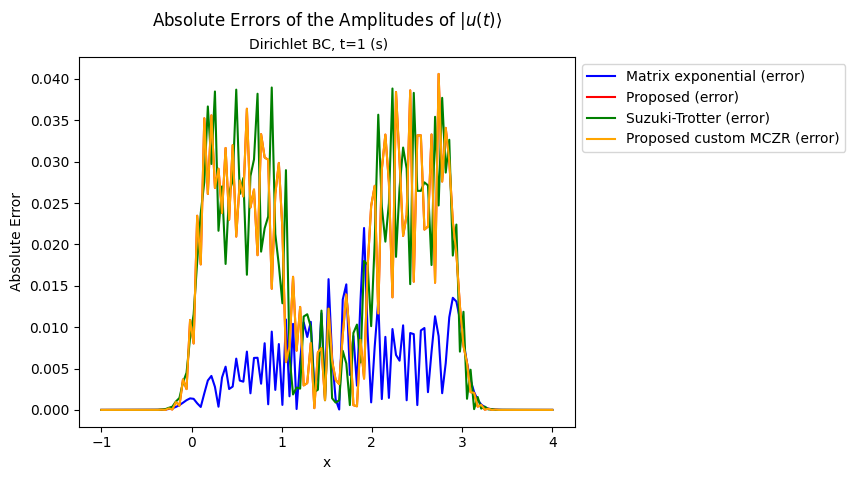

In [50]:
plt.figure()
plt.plot(
    x,
    np.abs(exact_solution - matrix_vector_simulation[-1]),
    label=f"Matrix exponential (error)",
    color="blue",
)
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_proposed_corrected),
    label=f"Proposed (error)",
    color="red",
)
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_trotter_corrected),
    label=f"Suzuki-Trotter (error)",
    color="green",
)
plt.plot(
    x,
    np.abs(exact_solution - amplitudes_proposed_custom_corrected),
    label=f"Proposed custom MCZR (error)",
    color="orange",
)
plt.title(f"Absolute Errors of the Amplitudes of " + r"$|u(t)\rangle$" + "\n")
plt.suptitle(f"Dirichlet BC, t={evolution_time} (s)", y=0.92, fontsize=10)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

## Analysis of CX-Gate Counts

In this section we analyze the number of CX-gates depending on the number of qubits used in the algorithm and the number of CX-gates depending on the number of Trotter steps.

To calculate the number of CX gates per qubit, we compare the implementation of the $V$ operator with the `suzuki_trotter` function from Classiq with the theoretical number of CX gates, for one Trotter step.

In theory, each Trotter step $\bigotimes_{\alpha=1}^{d}V(\gamma \tau \eta_\alpha, \lambda_\alpha)$ requires $d(9n^2-33n+34)$ CX gates (by Lemma 6). In case of the advection equation $d = 1$. However, the theoretical derivation does not include the CX-gates used to prepare the initial state. Therefore, in the code below, we use `allocate` instead of `prepare_amplitudes` for the results to be comparable. It is also worth noting that the theoretical derivation in the paper uses a special implementation of the MCRZ gate.

Let us define some helper functions:

In [51]:
def prepare_amplitude_vector(num_qubits):
    # Simulation parameters
    N = 2**num_qubits
    x = np.linspace(lb, ub, N)
    dx = (x[-1] - x[0]) / (N - 1)

    # Initial conditons at time t=0
    initial_vector = np.zeros((N))
    initial_vector[np.logical_and(x > 1, x < 2)] = 1

    # Normalization
    normalization_coefficient = np.linalg.norm(initial_vector)
    normal_vector = initial_vector / normalization_coefficient
    return normal_vector, dx


# Function used to calculate cx-gates in V operator method
def v_operator(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)

    # V Operator
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        allocate(
            num_qubits, q
        )  # here we use `alocate` to be able to compare results with the theory.
        repeat(
            count=steps,
            iteration=lambda index: V(params=[-np.pi / 2, 1 / (2 * dx), tau], q=q),
        )

    return main


def v_operator_custom(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)

    # V Operator
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        allocate(
            num_qubits, q
        )  # here we use `alocate` to be able to compare results with the theory.
        repeat(
            count=steps,
            iteration=lambda index: V_custom(
                params=[-np.pi / 2, 1 / (2 * dx), tau], q=q
            ),
        )

    return main


def suzuki_trotter_step(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)
    A = create_dirichlet_operator(2**num_qubits, dx)
    HAMILTONIAN = matrix_to_hamiltonian(-1j * v * A)

    # Suzuki-Trotter step
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        allocate(num_qubits, q)
        suzuki_trotter(
            HAMILTONIAN,
            evolution_coefficient=T,
            order=1,
            repetitions=steps,
            qbv=q,
        )

    return main


# Function to synthesize circuit and collect CX count and depth
def synthesize_and_collect(main, num_qubits):
    # Define and synthesize model
    qmod = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )
    qmod = set_constraints(qmod, Constraints(max_width=num_qubits))
    qmod = set_preferences(qmod, preferences)
    qprog = synthesize(qmod)

    # Extract CX count and depth from synthesized circuit
    cx_count = qprog.transpiled_circuit.count_ops["cx"]
    return cx_count

### CX gates count (number of qubits)

The code below evaluates the number of CX gates required for different quantum circuit implementations of one trotter step over a range of qubit numbers (`steps=1`).

In a loop, arrays are initialized to store CX gate counts for three types of circuits and theoretical counts:
- `CX (V)` - Proposed circuit
- `CX (V - custom MCRZ)`- Custom implementation of the proposed circuit
- `CX (Trotter)` - Suzuki-Trotter circuit.
- `CX theory` - A theoretical CX gate count is computed for comparison using the formula $9n^2-33n+34$, where $n$ is the number of qubits. This count does not include gates for preparing the initial state.

The results:
- qubit counts and
- corresponding CX gate counts for the different circuits

are stored in a dictionary `qubits_analysis_results` for visualization.

In [55]:
# Initialize arrays to collect CX counts and depths for proposed and Trotter circuits
cx_counts_proposed, cx_counts_trotter, cx_counts_proposed_custom = [], [], []

N = 7  # set to 12 to see the best result. However, the execution time is quite long.
# Loop through different numbers of qubits
for i in range(3, N):
    steps = 1
    num_qubits = i

    # Define V operator quantum function
    main = v_operator(num_qubits, steps)

    # Collect data for V-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_proposed.append(cx_count)

    main = v_operator_custom(num_qubits, steps)

    # Collect data for V-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_proposed_custom.append(cx_count)

    # Define Suzuki-Trotter quantum function
    main = suzuki_trotter_step(num_qubits, steps)

    # Collect data for Trotter-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_trotter.append(cx_count)

qubits_analysis_results = {
    "#qubits": range(3, N),
    "CX theory": [9 * i**2 - 33 * i + 34 for i in range(3, N)],
    "CX (V)": cx_counts_proposed,
    "CX (V - custom MCRZ)": cx_counts_proposed_custom,
    "CX (Trotter)": cx_counts_trotter,
}

#### Visualization (number of qubits)

In the graph below, you can see that the `suzuki_trotter` function requires more CX gates than the $V$ operator implementation. This is because the `suzuki_trotter` function decomposes the Hamiltonian into Pauli gates. For the advection equation, the Hamiltonian can be decomposed into $2^n - 1$ terms, where $n$ is the number of qubits. In contrast, the $V$ operator was specifically designed to address this issue and requires only a polynomial number of CX gates.

Multi-control-RZ (MCRZ) gates have been decomposed as follows:
- Using standard Classiq functionality for the "CX (Proposed)" results.
- Using the special decomposition proposed by [R. Vale et al., "Decomposition of Multi-controlled Special Unitary Single-Qubit Gates", arXiv:2302.06377](https://arxiv.org/abs/2302.06377) for the "Proposed custom MCRZ" results.

The CX results are compared with the theoretical counts of CX gates, "CX (theory)", calculated using the formula $9n^2 - 33n + 34$ (as stated in Lemma 6, where $d = 1$ for the advection equation).

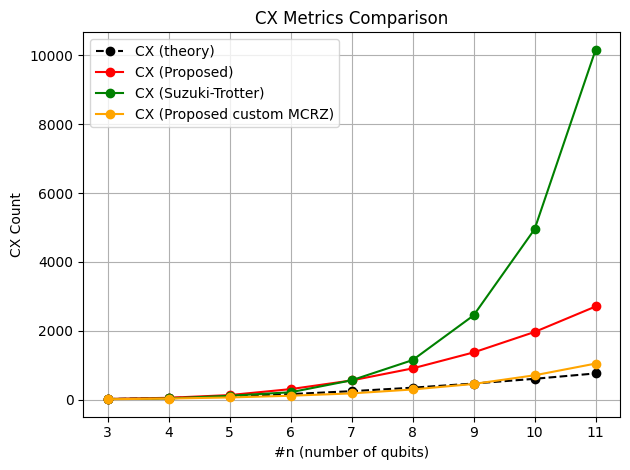

In [56]:
# Convert to pandas DataFrame
df_custom = pd.DataFrame(qubits_analysis_results)

plt.figure()
# CX metrics
plt.plot(
    df_custom["#qubits"],
    df_custom["CX theory"],
    label="CX (theory)",
    marker="o",
    linestyle="--",
    color="black",
)
plt.plot(
    df_custom["#qubits"],
    df_custom["CX (V)"],
    label="CX (Proposed)",
    marker="o",
    color="red",
)
plt.plot(
    df_custom["#qubits"],
    df_custom["CX (Trotter)"],
    label="CX (Suzuki-Trotter)",
    marker="o",
    color="green",
)
plt.plot(
    df_custom["#qubits"],
    df_custom["CX (V - custom MCRZ)"],
    label="CX (Proposed custom MCRZ)",
    marker="o",
    color="orange",
)

plt.title("CX Metrics Comparison")
plt.ylabel("CX Count")
plt.xlabel("#n (number of qubits)")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### CX gates count (Trotter steps)

As noted earlier, the time $T$ is related to the number of steps and $\tau$ by the following equation:

$$
T = \#steps \times \tau
$$

It is up to us to decide which variable will be dependent and which will be independent in our analysis. For this study, we chose to analyze the CX-gate count as a function of the number of Trotter steps, with the total time fixed at $T=1$, as done in previous simulations. Additionally, we compare the $V$ operator and `suzuki_trotter` implementations.

We anticipate that the number of CX gates will increase linearly with the number of Trotter steps. This expectation arises because the operators are applied $\#steps$ times to complete the circuit.

In this case, we include the `prepare_amplitudes` function to ensure comparability with our simulations for a fixed number of qubits to 7 (`num_qubits = 7`).

In [57]:
# Function used to calculate cx-gates in V operator method


def v_operator(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)

    # V Operator
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)
        repeat(
            count=steps,
            iteration=lambda index: V(params=[-np.pi / 2, 1 / (2 * dx), tau], q=q),
        )

    return main


# Function used to calculate cx-gates in V operator method
def v_operator_custom(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)

    # V Operator
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)
        repeat(
            count=steps,
            iteration=lambda index: V_custom(
                params=[-np.pi / 2, 1 / (2 * dx), tau], q=q
            ),
        )

    return main


def suzuki_trotter_step(num_qubits, steps):
    T = 1
    tau = T / steps
    normal_vector, dx = prepare_amplitude_vector(num_qubits)
    A = create_dirichlet_operator(2**num_qubits, dx)
    HAMILTONIAN = matrix_to_hamiltonian(-1j * v * A)

    # Suzuki-Trotter step
    @qfunc
    def main(q: Output[QArray[QBit, num_qubits]]):
        prepare_amplitudes(amplitudes=list(normal_vector), bound=0, out=q)
        suzuki_trotter(
            HAMILTONIAN,
            evolution_coefficient=T,
            order=1,
            repetitions=steps,
            qbv=q,
        )

    return main

The code below evaluates the number of CX gates required for different quantum circuit implementations over a range of Trotter steps (`steps`), from 1 to 100 in increments of 10, with the number of qubits fixed at 7 (`num_qubits = 7`).

In a loop, arrays are initialized to store CX gate counts for three types of circuits:
- `CX (V)` - Proposed circuit.
- `CX (V - custom MCRZ)` - Custom implementation of the proposed circuit with special decomposition of MCRZ gates.
- `CX (Trotter)` - Suzuki-Trotter circuit.

For each number of Trotter steps, the circuits are synthesized, and the corresponding CX gate counts are collected.

The results:
- Trotter step counts (`steps`) and
- CX gate counts for the different circuits (`cx_count`)

are stored in a dictionary `step_analysis_results` for visualization.


In [58]:
# Initialize arrays to collect CX counts and depths for proposed and Trotter circuits
cx_counts_proposed, cx_counts_trotter, num_steps, cx_counts_proposed_custom = (
    [],
    [],
    [],
    [],
)
num_qubits = 3  # value was set to 7 originally

# Loop through different numbers of qubits
for i in range(0, 10):
    # In original solution, we ran: for i in range(0, 101, 10):

    # Convert first step to 1
    if i == 0:
        i = 1
    steps = i

    num_steps.append(steps)
    # Define V operator quantum function
    main = v_operator(num_qubits, steps)

    # Collect data for V-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_proposed.append(cx_count)

    main = v_operator_custom(num_qubits, steps)

    # Collect data for V-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_proposed_custom.append(cx_count)

    # Define Suzuki-Trotter quantum function
    main = suzuki_trotter_step(num_qubits, steps)

    # Collect data for Trotter-circuit
    cx_count = synthesize_and_collect(main, num_qubits)
    cx_counts_trotter.append(cx_count)

step_analysis_results = {
    "#steps": num_steps,
    "CX (V)": cx_counts_proposed,
    "CX (Trotter)": cx_counts_trotter,
    "CX (V - custom MCRZ)": cx_counts_proposed_custom,
}

#### Visualization (Trotter steps)

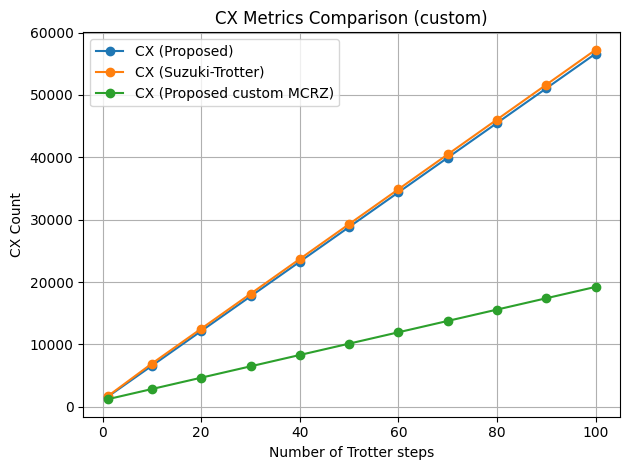

In [59]:
# Convert to pandas DataFrame
df_custom = pd.DataFrame(step_analysis_results)

plt.figure()

# CX metrics
plt.plot(df_custom["#steps"], df_custom["CX (V)"], label="CX (Proposed)", marker="o")
plt.plot(
    df_custom["#steps"],
    df_custom["CX (Trotter)"],
    label="CX (Suzuki-Trotter)",
    marker="o",
)
plt.plot(
    df_custom["#steps"],
    df_custom["CX (V - custom MCRZ)"],
    label="CX (Proposed custom MCRZ)",
    marker="o",
)

plt.title("CX Metrics Comparison (custom)")
plt.ylabel("CX Count")
plt.xlabel("Number of Trotter steps")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [60]:
output = None